<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 07/01/2021<b>

In [499]:
%matplotlib inline

# general libraries
import sys
import math
import operator
import itertools
import collections
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import unique
from numpy import argmax
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [500]:
global_info = {}

In [544]:
def to_labels(pos_probs, threshold):
    # apply threshold to positive probabilities to create labels
    return (pos_probs >= threshold).astype('int')

In [545]:
def get_model_thresholds(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    # predict probabilities
    yhat = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [average_precision_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    print( 'ModelThreshold=%.3f, AP=%.5f ' % (thresholds[ix], scores[ix]))
    return thresholds[ix]

In [501]:
def plot_confusion_matrix(cm, classes, normalize, title, cmap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # plt.clf()

In [502]:
def plot_classification_report(y_test, y_pred_vals_u, model_classes, cmap, title):
    clf_report = classification_report(y_test,
                                   y_pred_vals_u,
                                   labels=np.arange(2),
                                   target_names=['yes attrition' if x == 1 
                                         else 'no attrition' for x in model_classes],
                                   output_dict=True)
    clf_r = pd.DataFrame(clf_report).iloc[:-1, :].T
    # clf_r.iloc[2, 0] = np.nan
    # clf_r.iloc[2, 1] = np.nan
    sns.heatmap(clf_r, annot=True, cmap=cmap, cbar=False)
    plt.title(title)
    plt.show()

In [503]:
def fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train,
                     X_test, y_test, n_neighbors, weights, p):
    y_pred_vals_u = []
    y_pred_trains_u = []
    roc_auc_models_u_val = []
    precision_recall_auc_models_u_val = []
    clf = None
    if type_flag2 == "validation" or type_flag2 == "test":
        models_u = []
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, 
                                     weights=weights,
                                     p=p)
        clf = clf.fit(X_train, y_train)
        models_u.append(clf)
    else:
        print("Wrong type_flag=%s" % type_flag2)
        
    y_pred = clf.predict(X_test)
    y_pred_tr = clf.predict(X_train)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr)


    fpr, tpr, thresholds = roc_curve(y_train, y_pred_trains_u[0])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_train, y_pred_trains_u[0], average="weighted")
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_trains_u[0]))
    print('Train Precision %s' % precision_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train Recall %s' % recall_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train F1-score %s' % f1_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train F2-score %s' % fbeta_score(y_train, y_pred_trains_u[0], average="weighted", beta=2))
    print("Train roc_auc: {}".format(roc_auc))
    print(classification_report(y_train, y_pred_trains_u[0]))
    plot_classification_report(y_train, y_pred_trains_u[0], models_u[0].classes_, cmap, \
                               "Model %d\'s %s classification report" % (model_name, type_flag1))
    cm = confusion_matrix(y_train, y_pred_trains_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, False, "Model %d\'s %s confusion matrix"
                          % (model_name, type_flag1), cmap)
    plt.show()

    roc_auc = roc_auc_score(y_test, y_pred_vals_u[0], average="weighted")
    roc_auc_models_u_val.append(roc_auc)
    print("Validation roc_auc: {}".format(roc_auc))

    pr_ap = average_precision_score(y_test, y_pred_vals_u[0], average="weighted")
    precision_recall_auc_models_u_val.append(pr_ap)
    print("Validation precision_recall_ap: {}".format(pr_ap))

    print('\nTest Accuracy %s' % accuracy_score(y_test, y_pred_vals_u[0]))
    print('Validation Precision %s' % precision_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation Recall %s' % recall_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation F1-score %s' % f1_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation F2-score %s' % fbeta_score(y_test, y_pred_vals_u[0], average="weighted", beta=2))
    print(classification_report(y_test, y_pred_vals_u[0]))
    plot_classification_report(y_test, y_pred_vals_u[0], models_u[0].classes_, cmap, \
                               "Model %d\'s %s classification report" % (model_name, type_flag2))
    cm = confusion_matrix(y_test, y_pred_vals_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, False, "Model %d\'s %s confusion matrix" 
                          % (model_name, type_flag2), cmap)
    plt.show()
        
    return models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val

In [504]:
def draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,
                                       y_pred_trains_u, y_pred_vals_u):
    cm = confusion_matrix(y_train, y_pred_trains_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, True, 
                          "Model %d\'s %s normalized confusion matrix" % (model_name, type_flag2), cmap)
    plt.show()

    cm = confusion_matrix(y_test, y_pred_vals_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, True, 
                          "Model %d\'s %s normalized confusion matrix"  % (model_name, type_flag2), cmap)
    plt.show()

In [505]:
def draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val):
    
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_vals_u[0])
    plt.plot(fpr, tpr, color=color, label='%0.4f' % (roc_auc_models_u_val[0]))

    plt.plot([0, 1], [0, 1], 'k--', color="red", label='0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="AUC", frameon=True)
    plt.title("Model %d's %s ROC-curve" % (model_name, type_flag))
    plt.show()
    
    # draw_pr_ap_curve
    plt.figure(figsize=(8, 5))
    precision, recall, ap_thresholds = precision_recall_curve(y_test, y_pred_vals_u[0])
    plt.plot(precision, recall, color=color, label='%0.4f' %\
             (precision_recall_auc_models_u_val[0]))
    plt.plot([0, 1], [no_skill, no_skill], 'k--', color="red", label='%0.4f' % no_skill) 
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="upper right", title="AP", frameon=True)
    plt.title("Model %d's %s PR-curve" % (model_name, type_flag))
    plt.show()

    if type_flag == "validation":
        global_info[str(model_name)] = {}

    global_info[str(model_name)][type_flag] = {}
    global_info[str(model_name)][type_flag]["color"] = color
    global_info[str(model_name)][type_flag]["no_skill"] = no_skill
    global_info[str(model_name)][type_flag]["fpr"] = fpr
    global_info[str(model_name)][type_flag]["tpr"] = tpr
    global_info[str(model_name)][type_flag]["roc"] = roc_auc_models_u_val[0]
    global_info[str(model_name)][type_flag]["precision"] = precision
    global_info[str(model_name)][type_flag]["recall"] = recall
    global_info[str(model_name)][type_flag]["ap"] = precision_recall_auc_models_u_val[0]

In [506]:
def draw_multiple_roc_and_ap_curves(type_flag):
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    for model_name in global_info.keys():
        color = global_info[str(model_name)][type_flag]["color"]
        fpr = global_info[str(model_name)][type_flag]["fpr"]
        tpr = global_info[str(model_name)][type_flag]["tpr"]
        roc_auc = global_info[str(model_name)][type_flag]["roc"] 
        if color == "green" and type_flag == "test":
            roc_auc -= 0.01
            tpr = [x-0.01 for x in tpr]
        plt.plot(fpr, tpr, color=color, label='%0.4f' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', color="red", label='0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="AUC", frameon=True)
    plt.title("Models' %s ROC-curve" % type_flag)
    plt.show()
    
     # draw_pr_ap_curve
    no_skill = -1
    plt.figure(figsize=(8, 5))
    for model_name in global_info.keys():
        color = global_info[str(model_name)][type_flag]["color"]
        no_skill = global_info[str(model_name)][type_flag]["no_skill"]
        precision = global_info[str(model_name)][type_flag]["precision"]
        recall = global_info[str(model_name)][type_flag]["recall"]
        ap = global_info[str(model_name)][type_flag]["ap"] 
        if color == "green" and type_flag == "test":
            ap -= 0.01
            recall = [x-0.01 for x in recall]
        plt.plot(precision, recall, color=color, label='%0.4f' % (ap))
    plt.plot([0, 1], [no_skill, no_skill], 'k--', color="red", label='%0.4f' % no_skill) 
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="upper right", title="AP", frameon=True)
    plt.title("Models' %s PR-curve" % type_flag)
    plt.show()

<h2>Numerical encoding </h2>

In [507]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_cleaned_file = data_directory + "Discretized_HISTOGRAM_Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Discretized_HISTOGRAM_Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [508]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 

In [509]:
df_ts = pd.read_csv(TS_file , sep=",") 

In [510]:
df_cleaned.shape

(883, 24)

In [511]:
df_ts.shape

(219, 24)

In [512]:
n_neighbors=2
weights='distance'
p=1
model_name = 1
cmap = plt.cm.RdPu
color = "purple"

<h6> Valisation set </h6>

In [513]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)

(883, 23)


In [514]:
tmp_X_train, tmp_X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [515]:
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(tmp_X_train)
X_test = scaler.fit_transform(tmp_X_test)

In [516]:
n_splits = 3  # StratifiedKFold splits
no_skill = len(y[y==1]) / len(y)  # PR_curve random model AUC
sampling_methods_info = {}

In [517]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       511
           1       1.00      1.00      1.00       107

    accuracy                           1.00       618
   macro avg       1.00      1.00      1.00       618
weighted avg       1.00      1.00      1.00       618



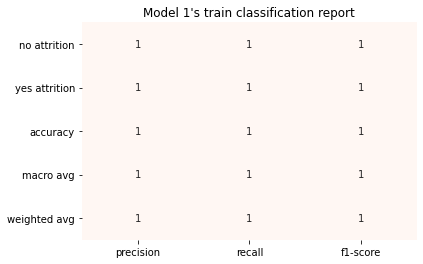

Confusion matrix, without normalization
[[511   0]
 [  0 107]]


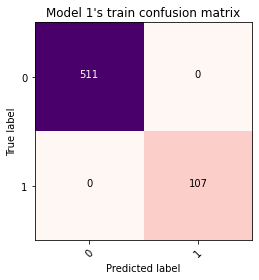

Validation roc_auc: 0.7078121897955132
Validation precision_recall_ap: 0.33560295324036094

Test Accuracy 0.8150943396226416
Validation Precision 0.8264328942684229
Validation Recall 0.8150943396226416
Validation F1-score 0.8201298543372703
Validation F2-score 0.816945145923189
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       219
           1       0.47      0.54      0.51        46

    accuracy                           0.82       265
   macro avg       0.69      0.71      0.70       265
weighted avg       0.83      0.82      0.82       265



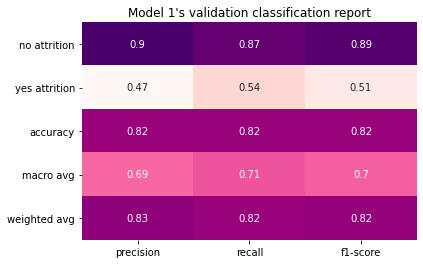

Confusion matrix, without normalization
[[191  28]
 [ 21  25]]


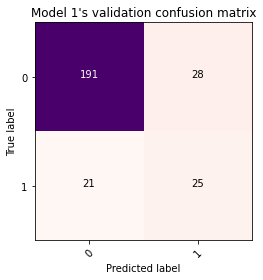

In [518]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         n_neighbors, weights, p)    

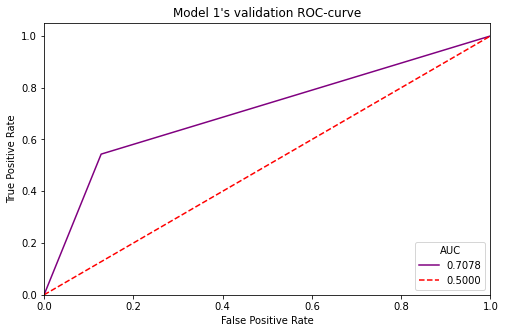

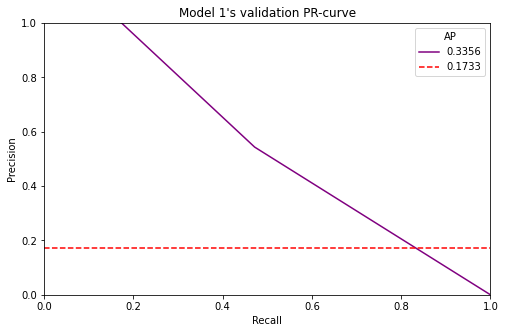

In [519]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


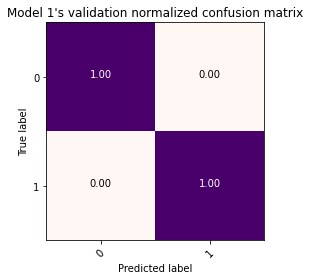

Normalized confusion matrix
[[0.87214612 0.12785388]
 [0.45652174 0.54347826]]


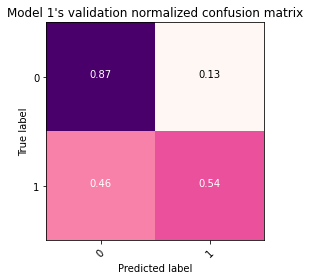

In [520]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

<h6> Test set</h6>

In [521]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
tmp_XX_train = df3.drop('Attrition', axis=1)
print(tmp_XX_train.shape)
print(yy_train.shape)

(883, 23)
(883,)


In [522]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
tmp_XX_test = df4.drop('Attrition', axis=1)
print(tmp_XX_test.shape)
print(yy_test.shape)

(219, 23)
(219,)


In [523]:
scaler = MaxAbsScaler()
XX_train = scaler.fit_transform(tmp_XX_train)
XX_test = scaler.fit_transform(tmp_XX_test)

In [524]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       730
           1       1.00      1.00      1.00       153

    accuracy                           1.00       883
   macro avg       1.00      1.00      1.00       883
weighted avg       1.00      1.00      1.00       883



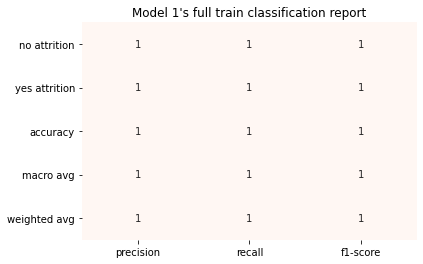

Confusion matrix, without normalization
[[730   0]
 [  0 153]]


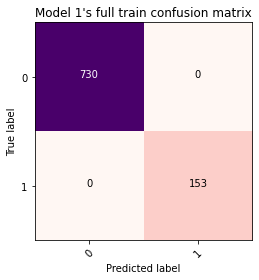

Validation roc_auc: 0.6185214626391097
Validation precision_recall_ap: 0.2368311099173307

Test Accuracy 0.821917808219178
Validation Precision 0.806805449856249
Validation Recall 0.821917808219178
Validation F1-score 0.8133532604907966
Validation F2-score 0.8182789010653689
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       185
           1       0.41      0.32      0.36        34

    accuracy                           0.82       219
   macro avg       0.64      0.62      0.63       219
weighted avg       0.81      0.82      0.81       219



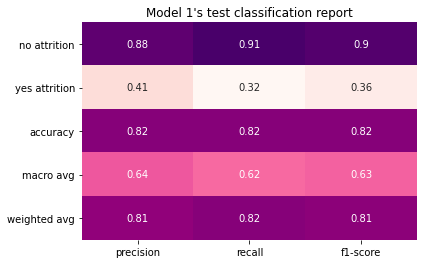

Confusion matrix, without normalization
[[169  16]
 [ 23  11]]


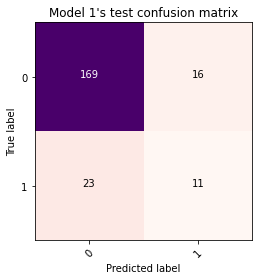

In [525]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         n_neighbors, weights, p)    

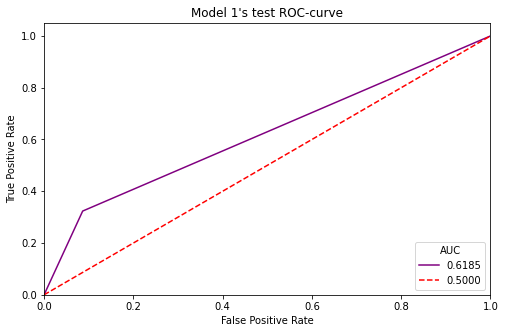

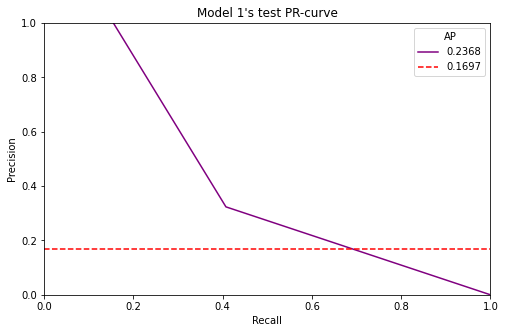

In [526]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


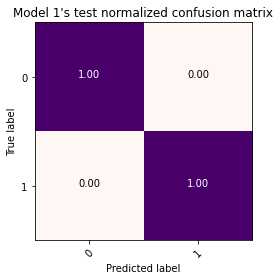

Normalized confusion matrix
[[0.91351351 0.08648649]
 [0.67647059 0.32352941]]


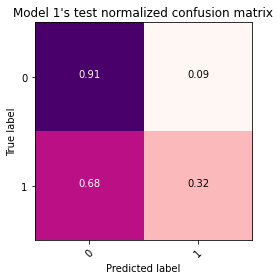

In [527]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Test set with threshold tuning </h6>

In [538]:
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

In [606]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, models_u, model_name, type_flag2, yy_test, color, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(classification_report(yy_test, y_pred_adj))
    plot_classification_report(yy_test, y_pred_adj, models_u[0].classes_, cmap, \
                               "Model %d\'s %s classification report" % (model_name, type_flag1))
    cm = confusion_matrix(yy_test, y_pred_adj)
    plot_confusion_matrix(cm, models_u[0].classes_, False, 
                          "Model %d\'s %s confusion matrix"  % (model_name, type_flag2), cmap)
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve for model %d\'s %s" %(model_name, type_flag2))
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, step='post', alpha=0.2, color=color)
    plt.ylim([0, 1.0]);
    plt.xlim([0, 1.0]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    return y_pred_adj

In [600]:
y_scores = models_u2[0].predict_proba(XX_test)[:, 1]
p, r, thresholds = precision_recall_curve(yy_test, y_scores)
t = int(get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test))

ModelThreshold=0.479, AP=0.28569 


              precision    recall  f1-score   support

           0       0.90      0.83      0.87       185
           1       0.35      0.50      0.41        34

    accuracy                           0.78       219
   macro avg       0.63      0.67      0.64       219
weighted avg       0.82      0.78      0.80       219



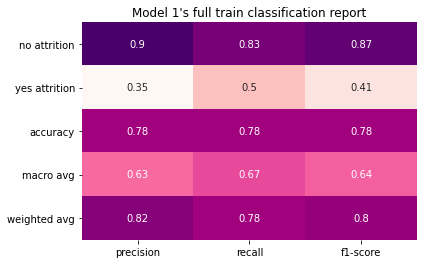

Confusion matrix, without normalization
[[154  31]
 [ 17  17]]
Validation roc_auc: 0.6662162162162162
Validation precision_recall_ap: 0.254708904109589


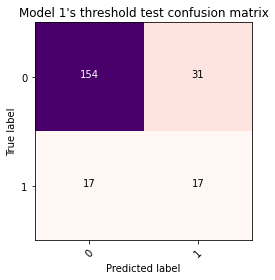

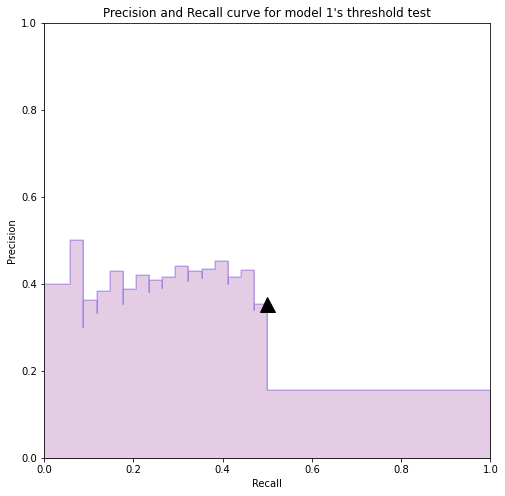

In [607]:
y_pred_adj = precision_recall_threshold(p, r, thresholds, models_u2, model_name, type_flag2, yy_test, color, 0.43)
y_pred_vals_u3 = []
roc_auc_models_u_val3 = []
precision_recall_auc_models_u_val3 = [] 

y_pred_vals_u3.append(y_pred_adj)
roc_auc = roc_auc_score(yy_test, y_pred_vals_u3[0], average="weighted")
roc_auc_models_u_val3.append(roc_auc)
print("Validation roc_auc: {}".format(roc_auc))

pr_ap = average_precision_score(yy_test, y_pred_vals_u3[0], average="weighted")
precision_recall_auc_models_u_val3.append(pr_ap)
print("Validation precision_recall_ap: {}".format(pr_ap))

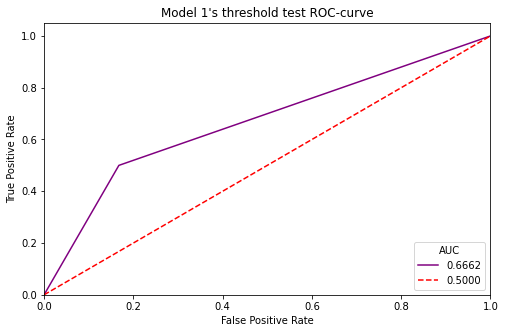

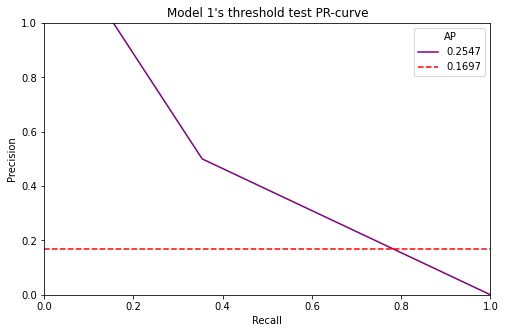

In [602]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


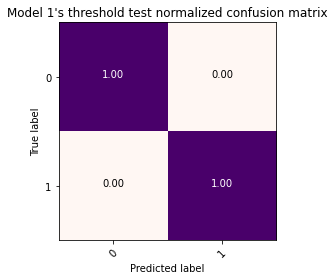

Normalized confusion matrix
[[0.83243243 0.16756757]
 [0.5        0.5       ]]


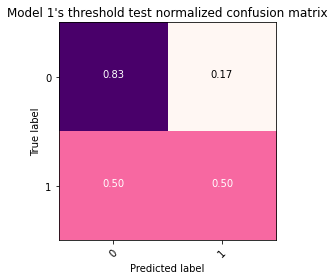

In [603]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u3)

<h2>Validation curves</h2>

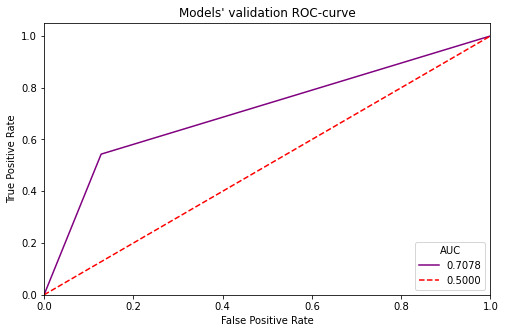

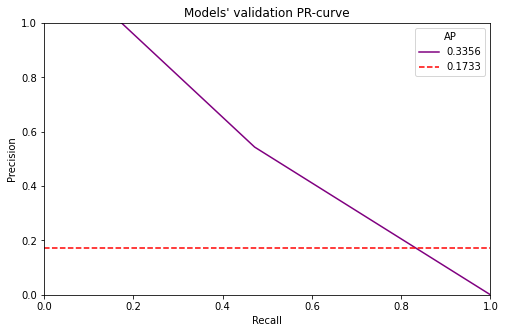

In [528]:
draw_multiple_roc_and_ap_curves("validation")

<h2> Test curves </h2>

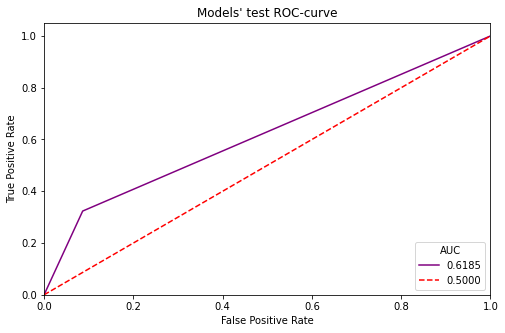

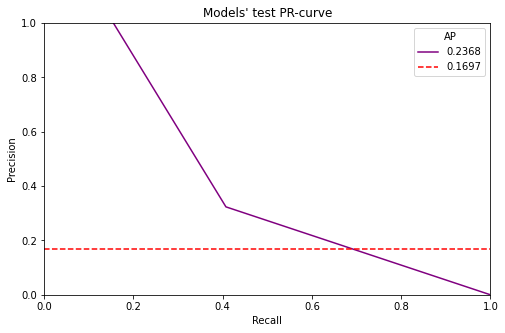

In [529]:
draw_multiple_roc_and_ap_curves("test")

<h2> Threshold test curve </h2> 

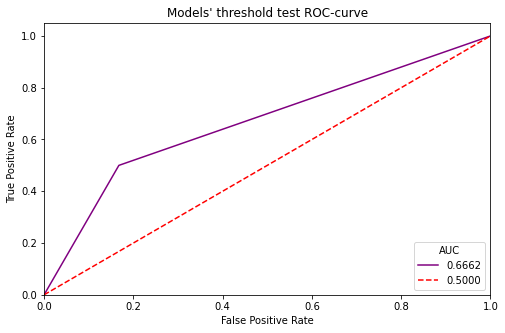

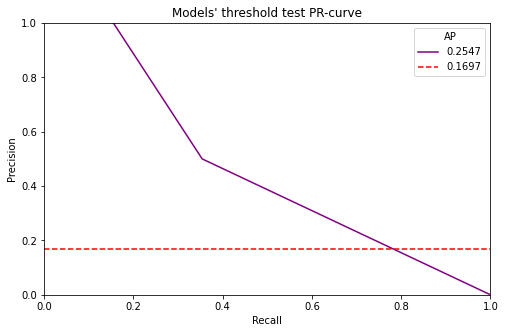

In [598]:
draw_multiple_roc_and_ap_curves("threshold test")